# EAM substrate lattice constants
probed for substrate block of crystal plane orientation [[1,-1,0],[1,1,-2],[1,1,1]] cell constant mutliples (51,30,8)  measures in xyz directions. Initial configuration created with
```python
FaceCenteredCubic('Au', directions=[[1,-1,0],[1,1,-2],[1,1,1]], size=(51,30,8), pbc=(1,1,0) )
```

In [1]:
%load_ext autoreload
%autoreload 2
%config Application.log_level="WARN"

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
import logging
from postprocessing import analyze_rdf, logger

In [3]:
# matplotlib settings

# expecially for presentation, larger font settings for plotting are recommendable
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 26

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure titlex

plt.rcParams["figure.figsize"] = (8,5) # the standard figure size

plt.rcParams["lines.linewidth"] = 4
plt.rcParams["lines.markersize"] = 14
plt.rcParams["lines.markeredgewidth"]=1 

In [3]:
def find_peak(rdf_file, peak_range = (4.0,4.2), plot = True, verbose = True, zero = 1e-8, bin_scale= 5 ):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from tabulate import tabulate
    # format is ovito 3.0.0-dev234 coordination analysis text output
    df = pd.read_csv(rdf_file,
        delim_whitespace=True,header=None,skiprows=3,index_col=0,
        names=['bin','distance','weight'])
    
    mean_bin_width = np.sum((df.distance - np.roll(df.distance,1))[1:]) / len(df[1:])
        
    selection = (df.distance > peak_range[0]) & (df.distance < peak_range[1])
    nonzero   = df.weight > zero
    #selected_bins = np.nonzero(selection)[0]
    non_zero_selected_bins = np.nonzero( selection & nonzero )[0]
    
    peak_position = ( np.sum(df.distance[selection]*df.weight[selection]) / np.sum(df.weight[selection]) )

    if plot:
        plt.bar(df.distance[selection],df.weight[selection], width = bin_scale*mean_bin_width)
        
    if verbose:
        msg = [ 
            ["Mean bin width:", "{:g}".format(mean_bin_width) ],
            ["Non-zero bins within selection:", *non_zero_selected_bins],
            ["According distances:", *df.distance[ non_zero_selected_bins ]],
            ["According weights:", *df.weight[ non_zero_selected_bins ]],
            ["Peak position:", "{:g}".format(peak_position)] ]
        print(tabulate(msg, tablefmt='plain')) # for fixed number format: floatfmt=".8f"
    
    return peak_position

## Initial configuration, approximate box measures

In [15]:
logger.setLevel(logging.INFO)

In [16]:
peak_positions = {}

[INFO - postprocessing.py:2351 - find_histogram_peak() ] Non-zero bins within selection:  10199        10200       10253       10486
According distances:                 4.0798       4.0802      4.1014      4.1946
According weights:                 770.398      366.764      56.5974     12.689
Peak position:                       4.08214 (2019-04-08 16:08:07,742)
[INFO - postprocessing.py:2379 - analyze_rdf() ] Peak position at 4.08214. (2019-04-08 16:08:07,743)
[INFO - postprocessing.py:2372 - plot_histogram() ] Mean bin width:  0.0004 (2019-04-08 16:08:07,746)


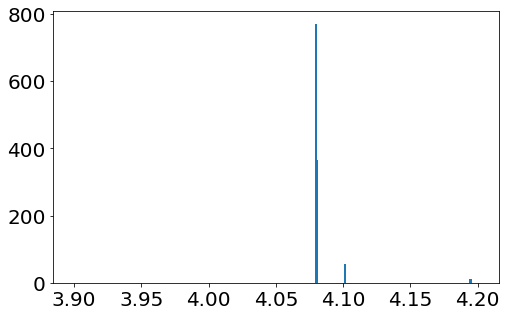

In [17]:
peak_positions["Initial configuration"] = analyze_rdf(
    '010_initial_config.txt', interval=(3.9,4.2))

## Minimized bulk, fixed box

For the following 3d-periodic minimizations, placed in a box approximately aligned to the lattice with LAMMPS input snippet

```LAMMPS
# [...]
# "tighten" box around system and add one lattice constant in all directions:
change_box all boundary s s s

# zero-align system
displace_atoms all move $((-xlo)) $((-ylo)) $((-zlo)) units box

# switch on periodic bc again
change_box all boundary p p p

# add one lattice constant in each direction

# default lattice constant for Au
variable substrate_lattice_constant index 4.07
# fcc lattice with (111) normal in z-direction
lattice fcc ${substrate_lattice_constant} orient x 1 -1 0 orient y 1 1 -2 orient z 1 1 1
# If the spacing option is not specified, the lattice spacings are computed by
# LAMMPS in the following way. A unit cell of the lattice is mapped into the
# simulation box (scaled and rotated), so that it now has (perhaps) a modified
# size and orientation. The lattice spacing in X is defined as the difference
# between the min/max extent of the x coordinates of the 8 corner points of the
# modified unit cell (4 in 2d). Similarly, the Y and Z lattice spacings are
# defined as the difference in the min/max of the y and z coordinates.

# Computed with the help of the following web tool
# http://neutron.ornl.gov/user_data/hb3a/exp16/tools/Crystal%20Plane%20Spacings%20and%20Interplanar%20Angles.htm
# the inter-planar spacings of [1,-1,0], [1,1,-2] and [1,1,1] are respectively
#   d = [2.878, 1.662, 2.35]
# Interestingly, the automatic computation of lattice spacings xlat,ylat,zlat
# in LAMMPS results in 
#   l = [5.75585, 6.64628, 7.04945], 
# which is the equivalent of
#   a*{Sqrt[2], Sqrt[8/3], Sqrt[3]} 
# with lattice constant a = 4.07 for Au.
# This correspongs to 
#   n = [2, 4, 3] = l / d (element-wise)
# crystal planes withinin each dimension within the LAMMPS-computed 
# lattice spacings.
change_box all x final $(xlo) $(xhi+(xlat/2.0)) y final $(ylo) $(yhi+(ylat/4.0)) z final $(zlo) $(zhi+(zlat/3.0)) units box
```


[INFO - postprocessing.py:2351 - find_histogram_peak() ] Non-zero bins within selection:  10006        10028
According distances:                 4.0026       4.0114
According weights:                 797.373      396.939
Peak position:                       4.00552 (2019-04-08 16:10:44,640)
[INFO - postprocessing.py:2379 - analyze_rdf() ] Peak position at 4.00552. (2019-04-08 16:10:44,642)
[INFO - postprocessing.py:2372 - plot_histogram() ] Mean bin width:  0.0004 (2019-04-08 16:10:44,645)


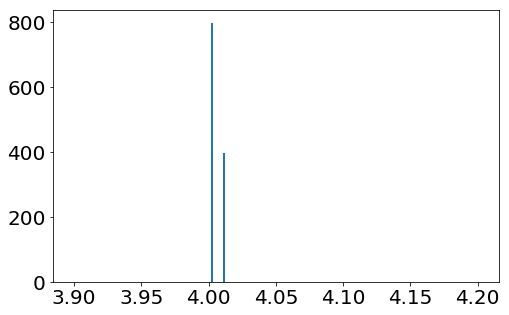

In [18]:
peak_positions["Minimized bulk, fixed box"] = analyze_rdf('020_bulk_minimized_box_fixed.txt', interval=(3.9,4.2))

## Minimized bulk, relaxed box

[INFO - postprocessing.py:2351 - find_histogram_peak() ] Non-zero bins within selection:  10175
According distances:                 4.0702
According weights:                1214.53
Peak position:                       4.0702 (2019-04-08 16:11:03,497)
[INFO - postprocessing.py:2379 - analyze_rdf() ] Peak position at 4.0702. (2019-04-08 16:11:03,498)
[INFO - postprocessing.py:2372 - plot_histogram() ] Mean bin width:  0.0004 (2019-04-08 16:11:03,502)


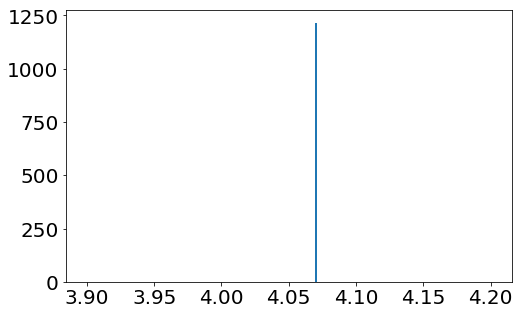

In [19]:
peak_positions["Minimized bulk, relaxed box"] = analyze_rdf('030_bulk_minimized_box_relaxed.txt', interval=(3.9,4.2))

## Minimized slab, fixed box

adedd vacuum slab in z-direction

[INFO - postprocessing.py:2351 - find_histogram_peak() ] Non-zero bins within selection:  10136        10174       10175       10185
According distances:                 4.0546       4.0698      4.0702      4.0742
According weights:                 250.51       205.15     1907.93      248.106
Peak position:                       4.06905 (2019-04-08 16:11:20,438)
[INFO - postprocessing.py:2379 - analyze_rdf() ] Peak position at 4.06905. (2019-04-08 16:11:20,439)
[INFO - postprocessing.py:2372 - plot_histogram() ] Mean bin width:  0.0004 (2019-04-08 16:11:20,444)


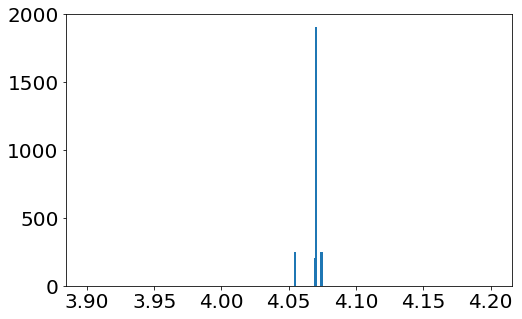

In [20]:
peak_positions["Minimized slab, fixed box"] = analyze_rdf('040_slab_minimized_box_fixed.txt', interval=(3.9,4.2))

## Minimized slab, relaxed box
box relaxed in xy directions

Mean bin width:                      0.0004
Non-zero bins within selection:  10129        10163       10173
According distances:                 4.0518       4.0654      4.0694
According weights:                 248.778     2100.49      246.63
Peak position:                       4.06448


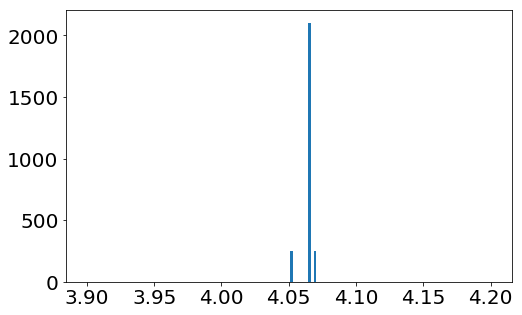

In [10]:
peak_positions["Minimized slab, relaxed box"] = find_peak('050_slab_minimized_box_relaxed.txt', peak_range=(3.9,4.2))

## 20 ps NVT bulk, temperature ramped 0 to 298K
final configuration

Mean bin width:                     0.0004
Non-zero bins within selection:  8783           8794           8807           8825           8838           8865           8905          8936          8938           8947           8952           8954           8966           8972           8977           8978          8985           8993         8996          8997           9000           9002          9004           9008           9012           9013           9014          9015           9020          9021           9029           9030          9031          9038           9041           9044           9049          9050          9052           9056           9057           9058          9061           9062           9064           9065           9066           9069           9070          9071           9073           9075           9080          9084           9085          9087           9088           9089           9091           9092           9094          9095           9097        

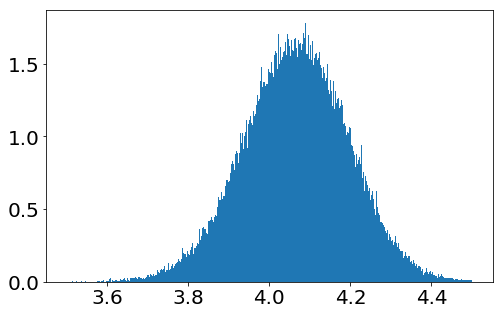

In [11]:
peak_positions["NVT 20ps bulk, final"] = find_peak('065_bulk_nvt_20_ps_0_to_298_K_ramped_final.txt', peak_range=(3.5,4.5))

## 20 ps NVT slab, temperature ramped 0 to 298K
final configuration

Mean bin width:                     0.0004
Non-zero bins within selection:  8804          8832          8851          8853          8864          8902         8914          8920          8921          8927          8947         8952          8954          8960          8961          8962          8973          8978          8980          8981          8984          8991          8997          9001          9009          9013          9017          9018          9020         9021          9022          9023          9033          9034          9039          9041          9042          9043          9046          9047          9048          9049          9055          9057          9058          9059          9061          9063          9066          9067          9071          9072          9073         9076          9077          9078          9079          9080          9082          9083          9084          9085          9089          9092         9093          9094          9095 

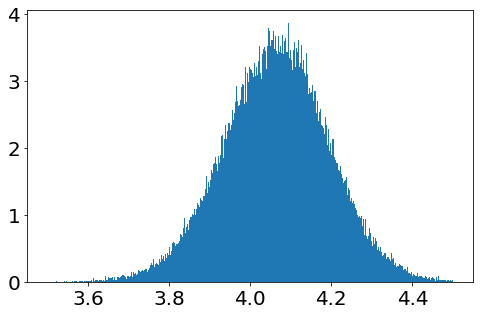

In [12]:
peak_positions["NVT 20ps slab, final"] = find_peak('060_slab_nvt_20_ps_0_to_298_K_ramped_final.txt', peak_range=(3.5,4.5))

## 200 ps NPT bulk, 298 K
### relaxed at zero pressure, final configuration

Mean bin width:                     0.0004
Non-zero bins within selection:  8808           8893           8894           8926           8929          8934           8944           8950           8957           8964           8966           8971          8973          8983          8984           8985           8990           8991           8995           8999           9001          9002           9004           9005           9013          9015          9016           9021          9024           9025           9033           9039           9044           9046           9047           9048           9049           9051           9056           9059           9064           9066           9067           9068          9069           9070          9075           9076          9079          9080           9081           9083           9085          9086          9087           9088          9089          9092           9094          9097          9104        9105         9108           91

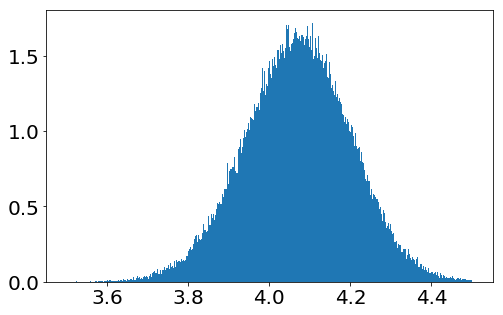

In [13]:
peak_positions["NPT 200ps bulk, final"] = find_peak('075_bulk_npt_200_ps_298_K_0_atm_final.txt', peak_range=(3.5,4.5))

### relaxed at zero pressure, averaged over all 1000 frames

In [3]:
rdf_ref = np.loadtxt('075_bulk_npt_200_ps_298_K_0_atm_final.txt')

In [32]:
df = pd.read_csv('075_bulk_npt_200_ps_298_K_0_atm_final.txt',
       delim_whitespace=True,header=None,skiprows=3,index_col=0,
       names=['bin','distance','weight'])


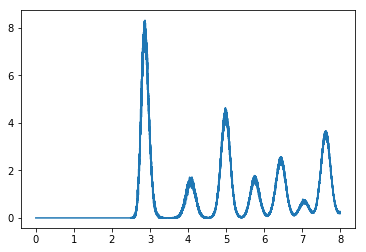

In [4]:
plt.plot(rdf_ref[:,1],rdf_ref[:,2])

In [35]:
rdf_tot = np.loadtxt('075_bulk_npt_200_ps_298_K_0_atm_total_rdf.txt')

In [36]:
df = pd.read_csv('075_bulk_npt_200_ps_298_K_0_atm_total_rdf.txt',
       delim_whitespace=True,header=None,skiprows=0,
       names=['distance','weight'])


In [37]:
df.index.name = 'bin'

In [40]:
type(())

tuple

In [41]:
df.shape

(20000, 2)

In [45]:
df.distance = np.linspace(0,8,df.shape[0]+1)[:-1]

In [47]:
df.tail()

,distance,weight
bin,,
19995,7.9980,237.153909
19996,7.9984,236.776415
19997,7.9988,236.615252
19998,7.9992,237.821789
19999,7.9996,237.720696


In [6]:
rdf_tot_3_col = np.append( 
    rdf_ref[:,0:2] ,
    np.reshape( rdf_tot[:,1], (len(rdf_tot[:,1]),1)), axis=1)

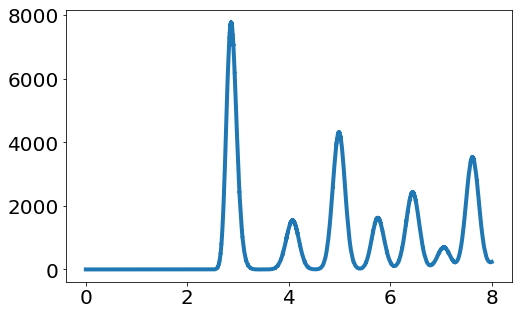

In [18]:
plt.plot(rdf_tot_3_col[:,1], rdf_tot_3_col[:,2] )

In [19]:
np.savetxt('075_bulk_npt_200_ps_298_K_0_atm_total_rdf_3_col.txt',
    rdf_tot_3_col,
    header='# 1: Bin number\n# 2: r\n# 3: g(r)')

Mean bin width:                     0.0004
Non-zero bins within selection:  8750         8751         8752         8753         8754         8755         8756         8757         8758         8759        8760         8761         8762         8763         8764         8765         8766         8767         8768         8769         8770         8771         8772         8773         8774         8775         8776         8777         8778         8779          8780         8781         8782         8783         8784         8785         8786         8787         8788         8789         8790         8791         8792         8793         8794         8795        8796         8797         8798         8799         8800         8801         8802         8803         8804        8805         8806         8807         8808         8809         8810         8811         8812         8813         8814        8815         8816         8817         8818         8819         8820         8821

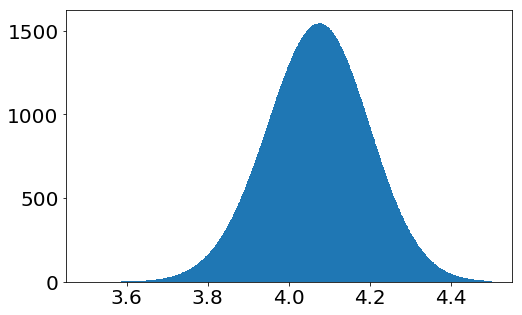

In [20]:
peak_positions["NPT 200ps bulk, average"] = find_peak('075_bulk_npt_200_ps_298_K_0_atm_total_rdf_3_col.txt', peak_range=(3.5,4.5))

## 200 ps NPT slab, 298 K
### relaxed in xy direction (zero pressure), final configuration

Mean bin width:                     0.0004
Non-zero bins within selection:  8766          8794         8820         8834          8837          8867          8892          8915          8916          8917          8918          8929          8935        8942          8952          8963          8966          8967          8973          8974          8976         8978          8980          8986          8987          9004          9005          9010          9011          9019          9020          9021          9023          9025          9026          9030          9042          9045          9053          9055          9056          9057          9059          9064          9065          9066          9068          9069          9070          9071          9072          9074          9076          9077          9078          9079          9083         9087          9088          9095          9096          9098          9099          9101          9105          9106          9107  

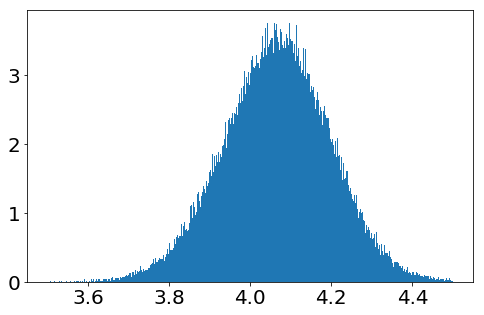

In [21]:
peak_positions["NPT 200ps slab, final"] = find_peak('070_slab_npt_200_ps_298_K_0_atm_final.txt', peak_range=(3.5,4.5))

### relaxed in xy direction (zero pressure), averaged over all 1000 frames

In [1]:
rdf_ref = np.loadtxt('070_slab_npt_200_ps_298_K_0_atm_final.txt')

NameError: name 'np' is not defined

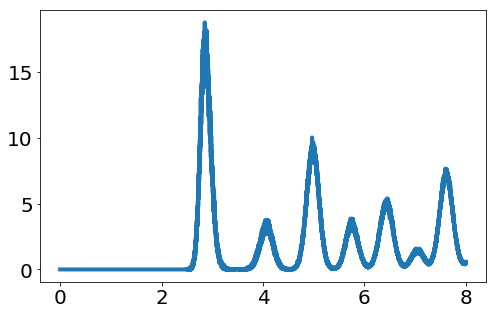

In [23]:
plt.plot(rdf_ref[:,1],rdf_ref[:,2])

In [24]:
rdf_tot = np.loadtxt('070_slab_npt_200_ps_298_K_0_atm_total_rdf.txt')

In [25]:
rdf_tot_3_col = np.append( 
    rdf_ref[:,0:2] ,
    np.reshape( rdf_tot[:,1], (len(rdf_tot[:,1]),1)), axis=1)

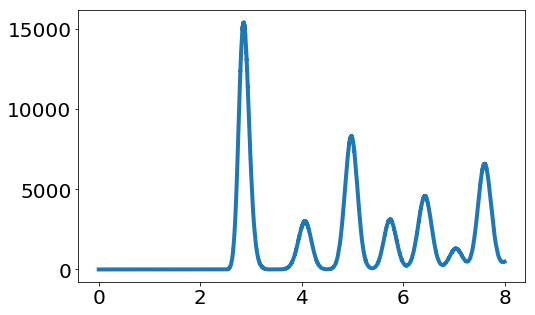

In [26]:
plt.plot(rdf_tot_3_col[:,1], rdf_tot_3_col[:,2] )

In [27]:
np.savetxt('070_slab_npt_200_ps_298_K_0_atm_total_rdf_3_col.txt',
    rdf_tot_3_col,
    header='# 1: Bin number\n# 2: r\n# 3: g(r)')

Mean bin width:                     0.0004
Non-zero bins within selection:  8750         8751        8752         8753         8754         8755         8756         8757         8758         8759         8760         8761         8762         8763         8764         8765         8766         8767         8768         8769         8770         8771         8772         8773         8774         8775         8776         8777         8778         8779         8780         8781         8782         8783         8784         8785         8786         8787         8788         8789         8790         8791         8792         8793         8794         8795        8796         8797         8798        8799         8800        8801         8802        8803         8804        8805        8806        8807        8808        8809        8810         8811        8812         8813         8814        8815        8816         8817        8818        8819        8820        8821        8822   

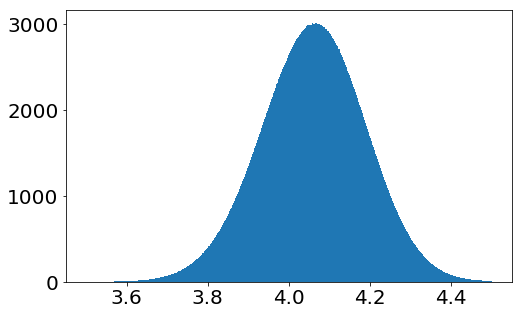

In [28]:
peak_positions["NPT 200ps slab, average"] = find_peak('070_slab_npt_200_ps_298_K_0_atm_total_rdf_3_col.txt', peak_range=(3.5,4.5))

# Summary

In [29]:
header = 'mean lattice constant (Angstrom)'

In [30]:
print(
    tabulate( zip(peak_positions.keys(), peak_positions.values()),
            headers  = ('',header),
            tablefmt = 'fancy_grid'))

╒═════════════════════════════╤════════════════════════════════════╕
│                             │   mean lattice constant (Angstrom) │
╞═════════════════════════════╪════════════════════════════════════╡
│ Initial configuration       │                            4.08214 │
├─────────────────────────────┼────────────────────────────────────┤
│ Minimized bulk, fixed box   │                            4.00552 │
├─────────────────────────────┼────────────────────────────────────┤
│ Minimized bulk, relaxed box │                            4.0702  │
├─────────────────────────────┼────────────────────────────────────┤
│ Minimized slab, fixed box   │                            4.06905 │
├─────────────────────────────┼────────────────────────────────────┤
│ Minimized slab, relaxed box │                            4.06448 │
├─────────────────────────────┼────────────────────────────────────┤
│ NVT 20ps bulk, final        │                            4.06612 │
├─────────────────────────────┼───

## by box measures:

In [81]:
cell_measures_bulk = np.loadtxt('075_bulk_npt_200_ps_298_K_0_atm_cell_measures.txt')

In [82]:
cell_measures_slab = np.loadtxt('070_slab_npt_200_ps_298_K_0_atm_cell_measures.txt')

In [83]:
cell_measures_slab[:,2] -= 60 # correction for 60 Ang vacuum

In [84]:
t = np.linspace(0,200.0,len(cell_measures_bulk))

## NPT 200 ps, bulk: xox measures

Text(0, 0.5, 'd ($\\AA$)')

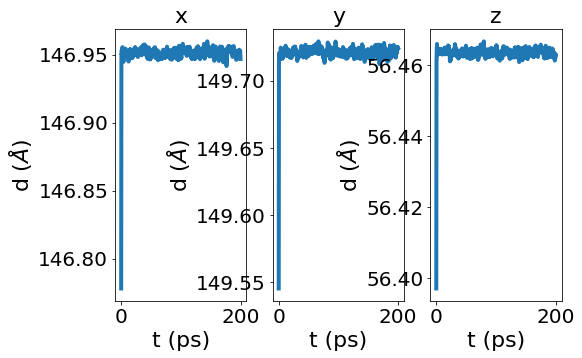

In [85]:
plt.subplot(131)
plt.plot(t, cell_measures_bulk[:,0], label='x' )
plt.title('x')
plt.xlabel("t (ps)")
plt.ylabel("d ($\AA$)")
plt.subplot(132)
plt.plot(t, cell_measures_bulk[:,1], label='y' )
plt.title('y')
plt.xlabel("t (ps)")
plt.ylabel("d ($\AA$)")
plt.subplot(133)
plt.plot(t, cell_measures_bulk[:,2], label='z' )
plt.title('z')
#plt.legend()
plt.xlabel("t (ps)")
plt.ylabel("d ($\AA$)")

## NPT 200 ps, slab: box measures

Text(0, 0.5, 'd ($\\AA$)')

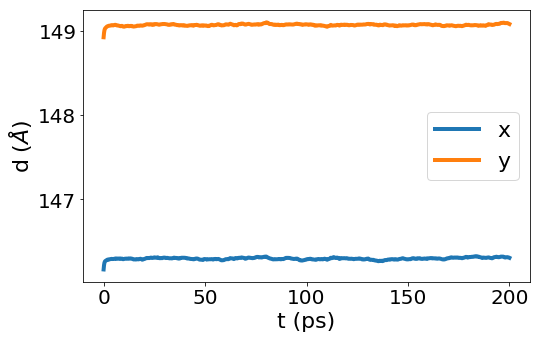

In [86]:
plt.plot(t, cell_measures_slab[:,0], label='x' )
plt.plot(t, cell_measures_slab[:,1], label='y' )
plt.legend()
plt.xlabel("t (ps)")
plt.ylabel("d ($\AA$)")

In [59]:
# cut off initial relaxation:

In [60]:
mean_measures_bulk = np.mean(cell_measures_bulk[100:,:],axis=0)

In [61]:
mean_measures_bulk

array([146.95116742, 149.72104496,  56.46358598])

In [62]:
mean_measures_slab = np.mean(cell_measures_slab[100:,:],axis=0)

In [63]:
mean_measures_slab

array([146.29863551, 149.07199195,  56.39710389])

In [64]:
# crystal orientation orient = [[1,-1,0], [1,1,-2], [1,1,1]]

In [65]:
# relation between plane_spacings in this oreintation and lattice constant:
plane_spacing_to_lattice_constant = np.array([np.sqrt(2), np.sqrt(6), np.sqrt(3)] )

In [66]:
plane_spacing_to_lattice_constant

array([1.41421356, 2.44948974, 1.73205081])

In [67]:
# 4.0702 is the bulk lattice constant minimized at 0 K
approximate_crystal_plane_spacing = 4.0702 / plane_spacing_to_lattice_constant

In [68]:
approximate_crystal_plane_spacing

array([2.87806602, 1.66165219, 2.34993107])

In [69]:
# expected number of crystal planes:

In [70]:
crystal_plane_count = np.round(mean_measures_bulk / approximate_crystal_plane_spacing)

In [71]:
crystal_plane_count

array([51., 90., 24.])

In [72]:
exact_crystal_plane_spacing_bulk = mean_measures_bulk / crystal_plane_count

In [73]:
exact_crystal_plane_spacing_slab = mean_measures_slab / crystal_plane_count

In [74]:
# deviations in % from 4.07 lattice spacing , bulk:
print(100.0*( exact_crystal_plane_spacing_bulk - approximate_crystal_plane_spacing) / approximate_crystal_plane_spacing)

[0.1156825  0.1152452  0.11567787]


In [75]:
# deviations in % from 4.07 lattice spacing, slab:
print(100.0* (exact_crystal_plane_spacing_slab - approximate_crystal_plane_spacing) / approximate_crystal_plane_spacing )

[-0.32887795 -0.3187626  -0.00220163]


In [76]:
exact_crystal_plane_spacing_bulk*plane_spacing_to_lattice_constant

array([4.07490851, 4.07489071, 4.07490832])

In [77]:
exact_crystal_plane_spacing_slab*plane_spacing_to_lattice_constant

array([4.05681401, 4.05722572, 4.07011039])

In [79]:
print(
    tabulate( [
        [
            'NPT 200 ps, bulk', 
            *(exact_crystal_plane_spacing_bulk*plane_spacing_to_lattice_constant)
        ], [
            'NPT 200 ps, slab', 
            *(exact_crystal_plane_spacing_slab*plane_spacing_to_lattice_constant)
        ] ],
        headers  = ('mean anisotropic lattice constants','x','y','z'),
        tablefmt = 'fancy_grid'))

╒══════════════════════════════════════╤═════════╤═════════╤═════════╕
│ mean anisotropic lattice constants   │       x │       y │       z │
╞══════════════════════════════════════╪═════════╪═════════╪═════════╡
│ NPT 200 ps, bulk                     │ 4.07491 │ 4.07489 │ 4.07491 │
├──────────────────────────────────────┼─────────┼─────────┼─────────┤
│ NPT 200 ps, slab                     │ 4.05681 │ 4.05723 │ 4.07011 │
╘══════════════════════════════════════╧═════════╧═════════╧═════════╛
